In [1]:
import pandas
from surnames_package import isonymic
from surnames_package import utils

In [11]:
pandas.read_parquet("../_products/departmental/get-merged-indicators-2021.parquet")

,department_id,n,ins,fst,fishers_alpha,a,b,v,m,population_2021
0,02007,178080,0.001474,0.000368,678.652960,0.125629,0.076286,0.003796,0.004033,257235
1,02014,141015,0.000938,0.000235,1066.096764,0.133000,0.062851,0.007503,0.010800,149371
2,02021,158948,0.001376,0.000344,726.899674,0.125230,0.072263,0.004552,0.005730,193425
3,02028,181426,0.001797,0.000449,556.543943,0.082094,0.082469,0.003058,0.003541,240437
4,02035,156586,0.001171,0.000293,853.647677,0.129648,0.069342,0.005422,0.006923,187670
...,...,...,...,...,...,...,...,...,...,...
517,90091,28105,0.010492,0.002623,95.312388,0.015478,0.195730,0.003380,0.004199,34613
518,90098,15279,0.016214,0.004054,61.674155,0.048956,0.261863,0.004020,0.005294,17708
519,90105,117860,0.004046,0.001011,247.158194,0.019922,0.108646,0.002093,0.002481,152557
520,90112,15870,0.006210,0.001552,161.040207,0.030435,0.138626,0.010046,0.011203,21710


In [6]:
departamental_df = pandas.merge(
    pandas.read_parquet("../_products/departmental/karlin-mcgregor-2001.parquet"),
    pandas.read_parquet("../_products/departmental/wright-2001.parquet"),
    on='department_id'
)

In [10]:
departamental_df.columns

Index(['department_id', 'v', 'n', 'fishers_alpha', 'a', 'b', 'population_2001',
       'ins', 'fst', 'm'],
      dtype='object')

In [36]:
departamental_df = utils.append_cell_description(
    df=departamental_df,
    departmentCodeColumn='department_id'
)

In [37]:
departamental_df['n'].sum()

19693370

In [38]:
departamental_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   department_id        510 non-null    object 
 1   v                    510 non-null    float64
 2   n                    510 non-null    int64  
 3   fishers_alpha        510 non-null    int64  
 4   a                    510 non-null    float64
 5   b                    510 non-null    float64
 6   population_2001      510 non-null    int64  
 7   ins                  510 non-null    float64
 8   fst                  510 non-null    float64
 9   m                    510 non-null    float64
 10  departamento_nombre  504 non-null    object 
 11  provincia_nombre     510 non-null    object 
 12  region_nombre        510 non-null    object 
 13  region_id            510 non-null    object 
dtypes: float64(6), int64(3), object(5)
memory usage: 59.8+ KB


In [39]:
import geopandas

In [40]:
departments_shape_file = "/home/lmorales/resources/departamentos.geojson"

In [41]:
shape = geopandas.read_file(departments_shape_file)

shape = shape[['departamento_id', 'provincia_id', 'geometry']]

In [42]:
shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   departamento_id  527 non-null    object  
 1   provincia_id     527 non-null    object  
 2   geometry         527 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 12.5+ KB


In [43]:
# [ ] - Combinar datos y capa
departmental_gdf = pandas.merge(
    shape,
    departamental_df,
    left_on='departamento_id',
    right_on='department_id'
)

In [44]:
import matplotlib.pyplot as plt

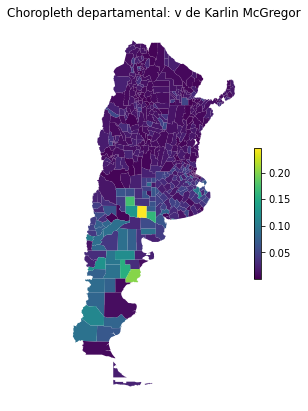

In [45]:
f, ax = plt.subplots(figsize=(4, 8))

departmental_gdf.plot(column='v', ax=ax, legend=True, legend_kwds={'shrink': 0.3})

ax.set_axis_off()
plt.title("Choropleth departamental: v de Karlin McGregor")
plt.show()

In [46]:
from surnames_package import spatial

In [47]:
NEIGHBORHOOD_STRATEGY = 'knn'
NEIGHBORHOOD_PARAM = 4

# [ ] - Calcular Moran global y locales
weights, moran, lisa = spatial.get_spatials(
    departmental_gdf,
    attribute='v',
    strategy=NEIGHBORHOOD_STRATEGY,
    k_neighbours=NEIGHBORHOOD_PARAM
)

SIGNIFICANCE_LIMIT = .05
# [ ] - Contar las cantidades por cada cluster
quadfilter = (lisa.p_sim <= (SIGNIFICANCE_LIMIT)) * (lisa.q)
spot_labels = ['not-significant', 'hot-spot', 'donut', 'cold-spot', 'diamond']
labels = [spot_labels[i] for i in quadfilter]

# [ ] - Asignar una nueva variable, proyectar las dos columnas de interés y guardar.
departmental_gdf['label'] = labels

In [48]:
from surnames_package import spatial_vis

tracts_palette {'Not significant': '#bababa', 'HH': '#d7191c', 'LH': '#abd9e9', 'LL': '#2c7bb6', 'HL': '#fdae61'}

edge_palette {'Not significant': 'white', 'HH': '#FFE6E6', 'LH': '#96b6f0', 'LL': '#050568', 'HL': '#F76E11'}


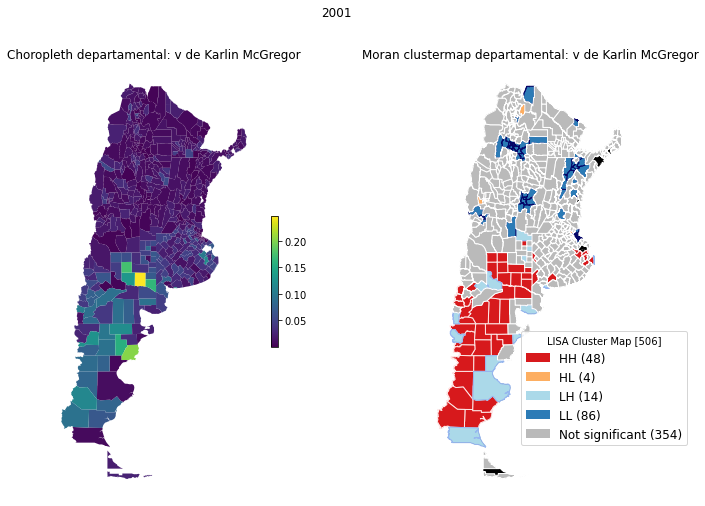

In [49]:
f, ax = plt.subplots(ncols=2, figsize=(12, 8))

departmental_gdf.plot(
    column='v',
    legend=True,
    legend_kwds={'shrink': 0.3},
    ax=ax[0])

ax[0].set_axis_off()
ax[0].set_title("Choropleth departamental: v de Karlin McGregor")

spatial_vis.create_clustermap_figure(
    departmental_gdf,
    shape,
    "Moran clustermap departamental: v de Karlin McGregor",
    ax=ax[1])

plt.suptitle("2001")
plt.show()

In [50]:
print("vmax=", departmental_gdf['v'].max())
print("vmin=",departmental_gdf['v'].min())

vmax= 0.246286
vmin= 0.000597


tracts_palette {'Not significant': '#bababa', 'HH': '#d7191c', 'LH': '#abd9e9', 'LL': '#2c7bb6', 'HL': '#fdae61'}

edge_palette {'Not significant': 'white', 'HH': '#FFE6E6', 'LH': '#96b6f0', 'LL': '#050568', 'HL': '#F76E11'}


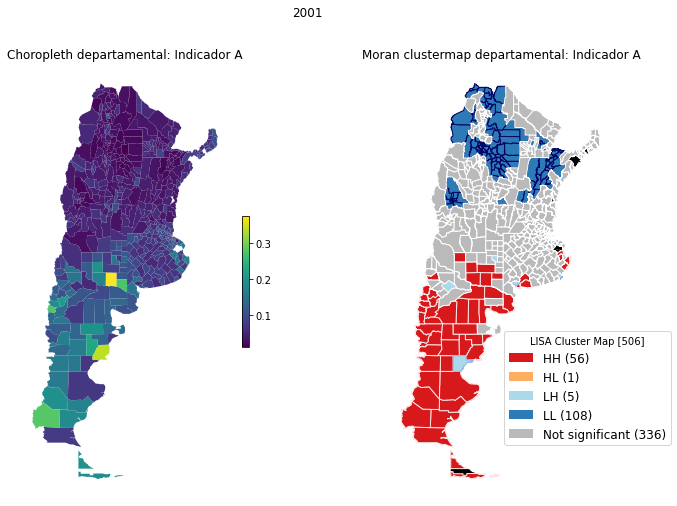

In [52]:
# [ ] - Calcular Moran global y locales
weights, moran, lisa = spatial.get_spatials(
    departmental_gdf,
    attribute='a',
    strategy=NEIGHBORHOOD_STRATEGY,
    k_neighbours=NEIGHBORHOOD_PARAM
)

SIGNIFICANCE_LIMIT = .05
# [ ] - Contar las cantidades por cada cluster
quadfilter = (lisa.p_sim <= (SIGNIFICANCE_LIMIT)) * (lisa.q)
spot_labels = ['not-significant', 'hot-spot', 'donut', 'cold-spot', 'diamond']
labels = [spot_labels[i] for i in quadfilter]

# [ ] - Asignar una nueva variable, proyectar las dos columnas de interés y guardar.
departmental_gdf['label'] = labels

f, ax = plt.subplots(ncols=2, figsize=(12, 8))

departmental_gdf.plot(
    column='a',
    legend=True,
    legend_kwds={'shrink': 0.3},
    ax=ax[0])

ax[0].set_axis_off()
ax[0].set_title("Choropleth departamental: Indicador A")

spatial_vis.create_clustermap_figure(
    departmental_gdf,
    shape,
    "Moran clustermap departamental: Indicador A",
    ax=ax[1])

plt.suptitle("2001")
plt.show()

In [53]:
print("vmax=", departmental_gdf['a'].max())
print("vmin=",departmental_gdf['a'].min())

vmax= 0.37407
vmin= 0.01407


tracts_palette {'Not significant': '#bababa', 'HH': '#d7191c', 'LH': '#abd9e9', 'LL': '#2c7bb6', 'HL': '#fdae61'}

edge_palette {'Not significant': 'white', 'HH': '#FFE6E6', 'LH': '#96b6f0', 'LL': '#050568', 'HL': '#F76E11'}


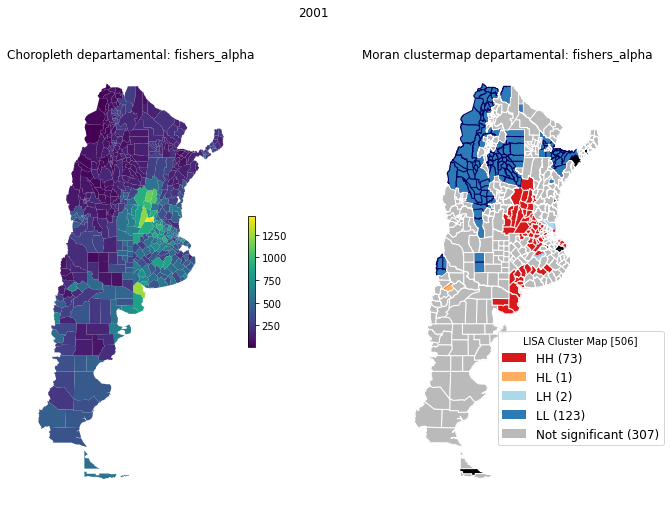

In [54]:
# [ ] - Calcular Moran global y locales
weights, moran, lisa = spatial.get_spatials(
    departmental_gdf,
    attribute='fishers_alpha',
    strategy=NEIGHBORHOOD_STRATEGY,
    k_neighbours=NEIGHBORHOOD_PARAM
)

SIGNIFICANCE_LIMIT = .05
# [ ] - Contar las cantidades por cada cluster
quadfilter = (lisa.p_sim <= (SIGNIFICANCE_LIMIT)) * (lisa.q)
spot_labels = ['not-significant', 'hot-spot', 'donut', 'cold-spot', 'diamond']
labels = [spot_labels[i] for i in quadfilter]

# [ ] - Asignar una nueva variable, proyectar las dos columnas de interés y guardar.
departmental_gdf['label'] = labels

f, ax = plt.subplots(ncols=2, figsize=(12, 8))

departmental_gdf.plot(
    column='fishers_alpha',
    legend=True,
    legend_kwds={'shrink': 0.3},
    ax=ax[0])

ax[0].set_axis_off()
ax[0].set_title("Choropleth departamental: fishers_alpha")

spatial_vis.create_clustermap_figure(
    departmental_gdf,
    shape,
    "Moran clustermap departamental: fishers_alpha",
    ax=ax[1])

plt.suptitle("2001")
plt.show()

In [55]:
print("vmax=", departmental_gdf['fishers_alpha'].max())
print("vmin=",departmental_gdf['fishers_alpha'].min())

vmax= 1456
vmin= 17


tracts_palette {'Not significant': '#bababa', 'HH': '#d7191c', 'LH': '#abd9e9', 'LL': '#2c7bb6', 'HL': '#fdae61'}

edge_palette {'Not significant': 'white', 'HH': '#FFE6E6', 'LH': '#96b6f0', 'LL': '#050568', 'HL': '#F76E11'}


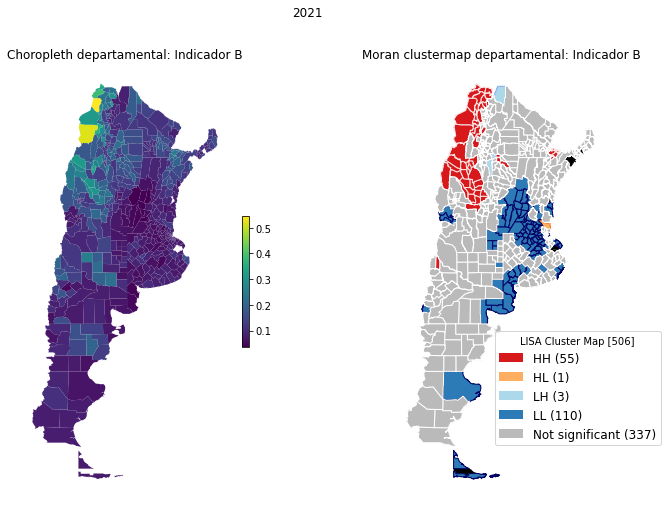

In [57]:
# [ ] - Calcular Moran global y locales
weights, moran, lisa = spatial.get_spatials(
    departmental_gdf,
    attribute='b',
    strategy=NEIGHBORHOOD_STRATEGY,
    k_neighbours=NEIGHBORHOOD_PARAM
)

SIGNIFICANCE_LIMIT = .05
# [ ] - Contar las cantidades por cada cluster
quadfilter = (lisa.p_sim <= (SIGNIFICANCE_LIMIT)) * (lisa.q)
spot_labels = ['not-significant', 'hot-spot', 'donut', 'cold-spot', 'diamond']
labels = [spot_labels[i] for i in quadfilter]

# [ ] - Asignar una nueva variable, proyectar las dos columnas de interés y guardar.
departmental_gdf['label'] = labels

f, ax = plt.subplots(ncols=2, figsize=(12, 8))

departmental_gdf.plot(
    column='b',
    legend=True,
    legend_kwds={'shrink': 0.3},
    ax=ax[0])

ax[0].set_axis_off()
ax[0].set_title("Choropleth departamental: Indicador B")

spatial_vis.create_clustermap_figure(
    departmental_gdf,
    shape,
    "Moran clustermap departamental: Indicador B",
    ax=ax[1])

plt.suptitle("2021")
plt.show()

tracts_palette {'Not significant': '#bababa', 'HH': '#d7191c', 'LH': '#abd9e9', 'LL': '#2c7bb6', 'HL': '#fdae61'}

edge_palette {'Not significant': 'white', 'HH': '#FFE6E6', 'LH': '#96b6f0', 'LL': '#050568', 'HL': '#F76E11'}


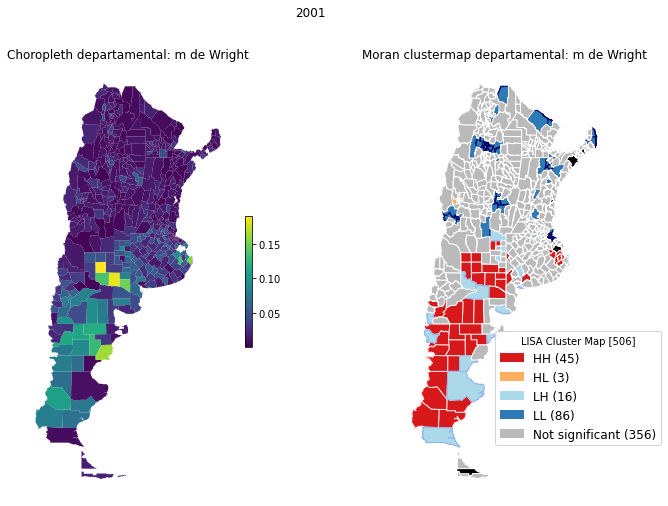

In [77]:
# [ ] - Calcular Moran global y locales
weights, moran, lisa = spatial.get_spatials(
    departmental_gdf,
    attribute='m',
    strategy=NEIGHBORHOOD_STRATEGY,
    k_neighbours=NEIGHBORHOOD_PARAM
)

SIGNIFICANCE_LIMIT = .05
# [ ] - Contar las cantidades por cada cluster
quadfilter = (lisa.p_sim <= (SIGNIFICANCE_LIMIT)) * (lisa.q)
spot_labels = ['not-significant', 'hot-spot', 'donut', 'cold-spot', 'diamond']
labels = [spot_labels[i] for i in quadfilter]

# [ ] - Asignar una nueva variable, proyectar las dos columnas de interés y guardar.
departmental_gdf['label'] = labels

f, ax = plt.subplots(ncols=2, figsize=(12, 8))

departmental_gdf.plot(
    column='m',
    legend=True,
    legend_kwds={'shrink': 0.3},
    ax=ax[0])

ax[0].set_axis_off()
ax[0].set_title("Choropleth departamental: m de Wright")

spatial_vis.create_clustermap_figure(
    departmental_gdf,
    shape,
    "Moran clustermap departamental: m de Wright",
    ax=ax[1])

plt.suptitle("2001")
plt.show()

In [76]:
print("vmax=", departmental_gdf['m'].max())
print("vmin=",departmental_gdf['m'].min())

vmax= 0.19045806789247244
vmin= 0.0005777675566737139


# Correlaciones

In [74]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def get_spearman(data, xcol, ycol):
    # calculate spearman's correlation
    corr, pvalue = spearmanr(
        data[xcol],
        data[ycol]
    )
    return corr, pvalue

def get_pearson(data, xcol, ycol):
    # calculate spearman's correlation
    corr, pvalue = pearsonr(
        data[xcol],
        data[ycol]
    )
    return corr, pvalue

In [65]:
pearson_corr, pearson_pvalue = get_pearson(departamental_df, 'v', 'm')
spearman_corr, spearman_pvalue = get_spearman(departamental_df, 'v', 'm')

print(f"Pearson correlation for departments of Argentina: {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
print(f"Spearmans correlation for departments of Argentina: {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")


Pearson correlation for departments of Argentina: 0.951 (p-value: 0.000)
Spearmans correlation for departments of Argentina: 0.985 (p-value: 0.000)


In [68]:
print("Correlation between: v and m")

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    pearson_corr, pearson_pvalue = get_pearson(region_records, 'v', 'm')
    print(f"Pearson correlation for Region '{region_name}': {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
    
print()

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    spearman_corr, spearman_pvalue = get_spearman(region_records, 'v', 'm')
    print(f"Spearmans correlation for Region '{region_name}': {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()


Correlation between: v and m
Pearson correlation for Region 'Centro': 0.930 (p-value: 0.000)
Pearson correlation for Region 'Cuyo': 0.965 (p-value: 0.000)
Pearson correlation for Region 'NEA': 0.969 (p-value: 0.000)
Pearson correlation for Region 'NOA': 0.976 (p-value: 0.000)
Pearson correlation for Region 'Patagonia': 0.962 (p-value: 0.000)

Spearmans correlation for Region 'Centro': 0.979 (p-value: 0.000)
Spearmans correlation for Region 'Cuyo': 0.974 (p-value: 0.000)
Spearmans correlation for Region 'NEA': 0.963 (p-value: 0.000)
Spearmans correlation for Region 'NOA': 0.983 (p-value: 0.000)
Spearmans correlation for Region 'Patagonia': 0.965 (p-value: 0.000)



In [78]:
print("Correlation between: v and m")

pearson_corr, pearson_pvalue = get_pearson(departamental_df, 'v', 'm')
spearman_corr, spearman_pvalue = get_spearman(departamental_df, 'v', 'm')

print(f"Pearson correlation for departments of Argentina: {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
print(f"Spearmans correlation for departments of Argentina: {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()
print()

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    pearson_corr, pearson_pvalue = get_pearson(region_records, 'v', 'm')
    print(f"Pearson correlation for Region '{region_name}': {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
    
print()

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    spearman_corr, spearman_pvalue = get_spearman(region_records, 'v', 'm')
    print(f"Spearmans correlation for Region '{region_name}': {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()


Correlation between: v and m
Pearson correlation for departments of Argentina: 0.951 (p-value: 0.000)
Spearmans correlation for departments of Argentina: 0.985 (p-value: 0.000)


Pearson correlation for Region 'Centro': 0.930 (p-value: 0.000)
Pearson correlation for Region 'Cuyo': 0.965 (p-value: 0.000)
Pearson correlation for Region 'NEA': 0.969 (p-value: 0.000)
Pearson correlation for Region 'NOA': 0.976 (p-value: 0.000)
Pearson correlation for Region 'Patagonia': 0.962 (p-value: 0.000)

Spearmans correlation for Region 'Centro': 0.979 (p-value: 0.000)
Spearmans correlation for Region 'Cuyo': 0.974 (p-value: 0.000)
Spearmans correlation for Region 'NEA': 0.963 (p-value: 0.000)
Spearmans correlation for Region 'NOA': 0.983 (p-value: 0.000)
Spearmans correlation for Region 'Patagonia': 0.965 (p-value: 0.000)



### V y alfa de fisher:

In [72]:
print("Correlation between: v and fishers_alpha")

pearson_corr, pearson_pvalue = get_pearson(departamental_df, 'v', 'fishers_alpha')
spearman_corr, spearman_pvalue = get_spearman(departamental_df, 'v', 'fishers_alpha')

print(f"Pearson correlation for departments of Argentina: {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
print(f"Spearmans correlation for departments of Argentina: {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()
print("Correlation between: v and fishers_alpha")

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    pearson_corr, pearson_pvalue = get_pearson(region_records, 'v', 'fishers_alpha')
    print(f"Pearson correlation for Region '{region_name}': {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
    
print()

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    spearman_corr, spearman_pvalue = get_spearman(region_records, 'v', 'fishers_alpha')
    print(f"Spearmans correlation for Region '{region_name}': {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()


Correlation between: v and fishers_alpha
Pearson correlation for departments of Argentina: -0.022 (p-value: 0.620)
Spearmans correlation for departments of Argentina: 0.020 (p-value: 0.651)

Correlation between: v and fishers_alpha
Pearson correlation for Region 'Centro': -0.263 (p-value: 0.000)
Pearson correlation for Region 'Cuyo': -0.441 (p-value: 0.002)
Pearson correlation for Region 'NEA': 0.067 (p-value: 0.564)
Pearson correlation for Region 'NOA': -0.319 (p-value: 0.000)
Pearson correlation for Region 'Patagonia': -0.498 (p-value: 0.000)

Spearmans correlation for Region 'Centro': -0.198 (p-value: 0.003)
Spearmans correlation for Region 'Cuyo': -0.519 (p-value: 0.000)
Spearmans correlation for Region 'NEA': 0.011 (p-value: 0.923)
Spearmans correlation for Region 'NOA': -0.423 (p-value: 0.000)
Spearmans correlation for Region 'Patagonia': -0.510 (p-value: 0.000)



In [73]:
print("Correlation between: v and A index")

pearson_corr, pearson_pvalue = get_pearson(departamental_df, 'v', 'a')
spearman_corr, spearman_pvalue = get_spearman(departamental_df, 'v', 'a')

print(f"Pearson correlation for departments of Argentina: {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
print(f"Spearmans correlation for departments of Argentina: {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()
print("Correlation between: v and A index")

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    pearson_corr, pearson_pvalue = get_pearson(region_records, 'v', 'a')
    print(f"Pearson correlation for Region '{region_name}': {pearson_corr:.3f} (p-value: {pearson_pvalue:.3f})")
    
print()

for region_name, region_records in departamental_df.groupby(by='region_nombre'):
    
    spearman_corr, spearman_pvalue = get_spearman(region_records, 'v', 'a')
    print(f"Spearmans correlation for Region '{region_name}': {spearman_corr:.3f} (p-value: {spearman_pvalue:.3f})")

print()


Correlation between: v and A index
Pearson correlation for departments of Argentina: 0.821 (p-value: 0.000)
Spearmans correlation for departments of Argentina: 0.701 (p-value: 0.000)

Correlation between: v and A index
Pearson correlation for Region 'Centro': 0.813 (p-value: 0.000)
Pearson correlation for Region 'Cuyo': 0.366 (p-value: 0.012)
Pearson correlation for Region 'NEA': 0.548 (p-value: 0.000)
Pearson correlation for Region 'NOA': 0.808 (p-value: 0.000)
Pearson correlation for Region 'Patagonia': 0.728 (p-value: 0.000)

Spearmans correlation for Region 'Centro': 0.699 (p-value: 0.000)
Spearmans correlation for Region 'Cuyo': 0.419 (p-value: 0.004)
Spearmans correlation for Region 'NEA': 0.607 (p-value: 0.000)
Spearmans correlation for Region 'NOA': 0.753 (p-value: 0.000)
Spearmans correlation for Region 'Patagonia': 0.656 (p-value: 0.000)

